In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

In [23]:
real_estate: pd.DataFrame = pd.read_excel('data/Real estate valuation data set.xlsx')
real_estate.drop(['No'], axis=1, inplace=True)

short = real_estate.copy()
short.columns = short.columns.map(lambda x: x.split(' ')[0])
display(short.head())

,X1,X2,X3,X4,X5,X6,Y
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [24]:
X_matrix: np.ndarray = np.array(real_estate.drop(['Y house price of unit area'], axis=1))
y_matrix: np.ndarray = np.array(real_estate['Y house price of unit area']).reshape(-1, 1)

X_train: np.ndarray = X_matrix[0:315]
y_train: np.ndarray = y_matrix[0:315]

X_test: np.ndarray = X_matrix[315:]
y_test: np.ndarray = y_matrix[315:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((315, 6), (315, 1), (99, 6), (99, 1))

In [153]:
from NeuralNet import NeuralNet

/Users/nacho/opt/anaconda3/envs/coding/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


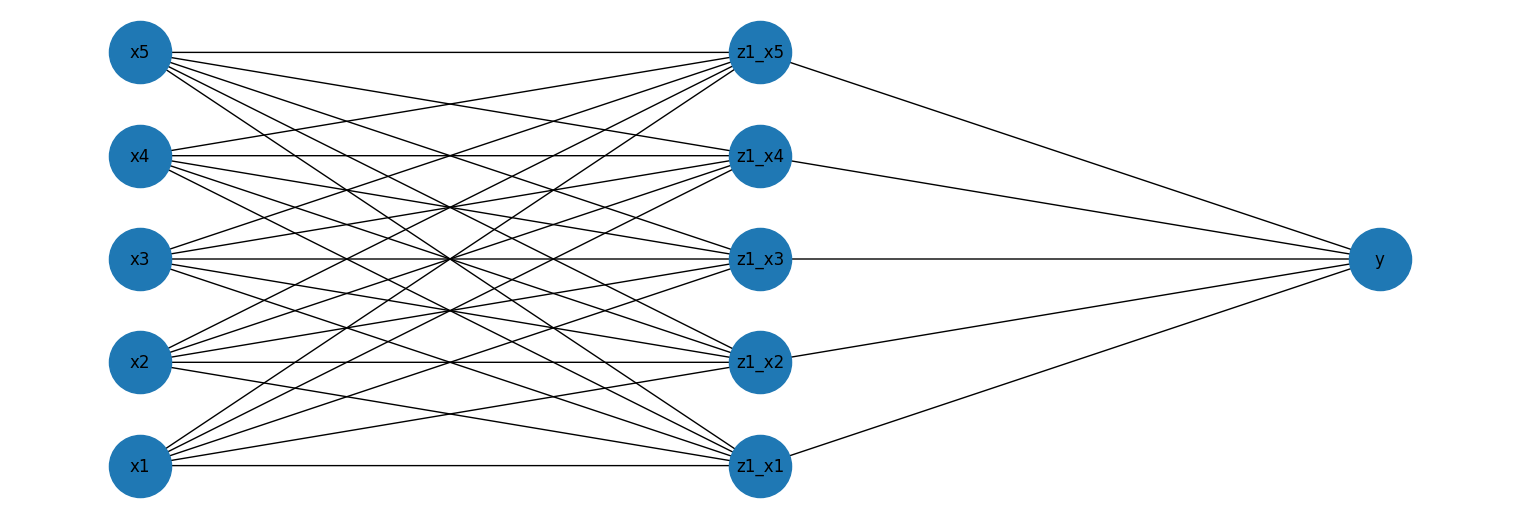

In [26]:
nn = NeuralNet()

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#no border
_ = fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
_ = ax.axis('off')
_ = nn.plot_network_graph(ax)

In [27]:
loss = nn.fit(X_train, y_train, lr=0.001, epochs=1000)

In [28]:
y_test[0]

array([27.3])

In [29]:
nn.predict(X_test[0].reshape(1, -1))

array([[38.02380314]])

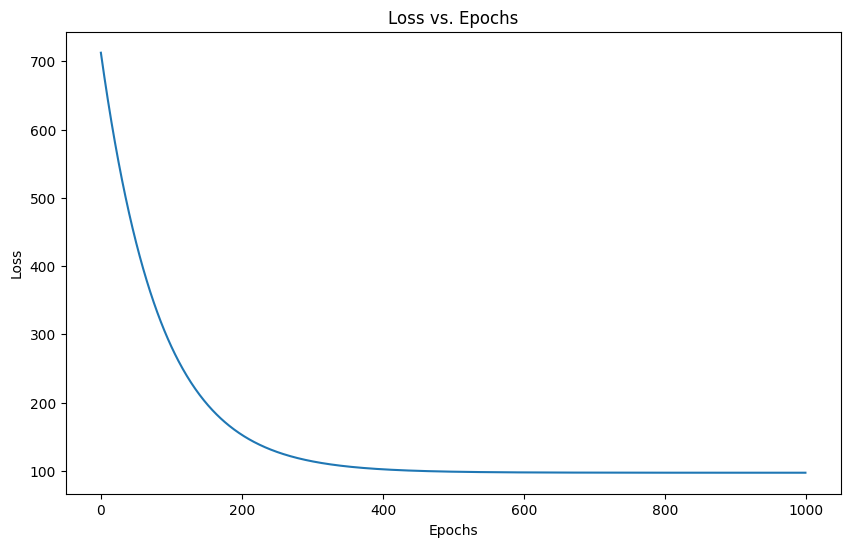

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss vs. Epochs')
plt.show()

In [31]:
# Error cuadrático medio

nn.mse(y_test, X_test)

154.30327394080933

100%|██████████| 30/30 [01:56<00:00,  3.88s/it]


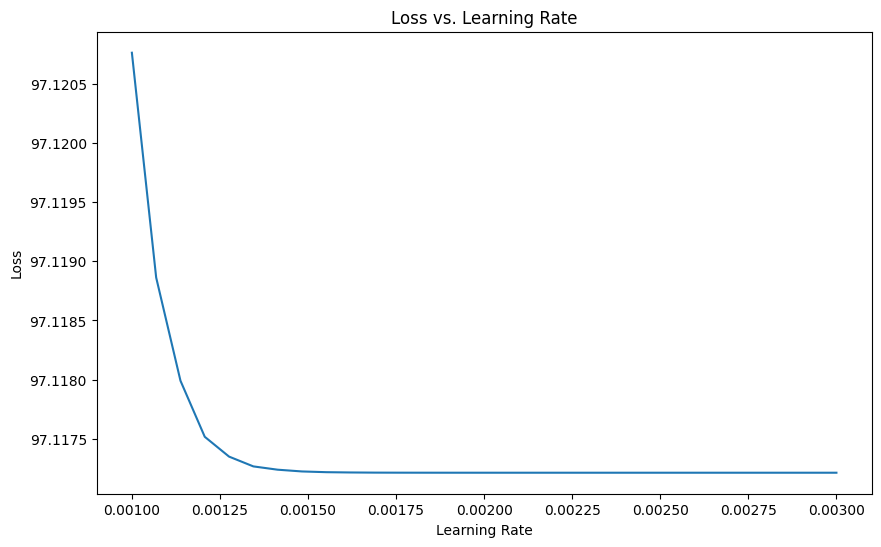

In [32]:
# Brute force para encontrar el mejor learning rate

lrs = np.linspace(0.001, 0.003, 30)
losses = []

for lr in tqdm(lrs):
    nn = NeuralNet()
    nn.fit(X_train, y_train, lr=lr, epochs=1000)
    losses.append(nn.get_loss()[-1])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lrs, losses)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Loss')
ax.set_title('Loss vs. Learning Rate')
plt.show()

In [33]:
list(zip(lrs, losses))

[(0.001, array([97.12076545])),
 (0.0010689655172413793, array([97.11886305])),
 (0.0011379310344827587, array([97.11799004])),
 (0.001206896551724138, array([97.11751553])),
 (0.0012758620689655173, array([97.11734794])),
 (0.0013448275862068967, array([97.11726508])),
 (0.001413793103448276, array([97.11723719])),
 (0.0014827586206896553, array([97.11722236])),
 (0.0015517241379310346, array([97.11721617])),
 (0.001620689655172414, array([97.11721372])),
 (0.0016896551724137933, array([97.11721243])),
 (0.0017586206896551726, array([97.11721196])),
 (0.0018275862068965517, array([97.11721176])),
 (0.001896551724137931, array([97.11721166])),
 (0.0019655172413793106, array([97.11721162])),
 (0.0020344827586206895, array([97.1172116])),
 (0.0021034482758620692, array([97.1172116])),
 (0.002172413793103448, array([97.11721159])),
 (0.002241379310344828, array([97.11721159])),
 (0.002310344827586207, array([97.11721159])),
 (0.0023793103448275866, array([97.11721159])),
 (0.0024482758620

In [34]:
m = min(losses)
#first occurrence of minimum
m_i = 30
for i, v in enumerate(losses):
    if v == m:
        m_i = i
        break

m_lr = lrs[m_i]

m_lr, m

(0.003, array([97.11721159]))

97.11752374395932

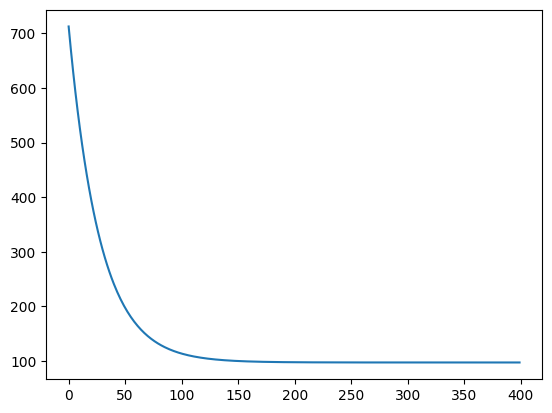

In [35]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, lr=0.003, epochs=400)
display(loss[-1][0])
_ = plt.plot(loss)

array([97.18213131])

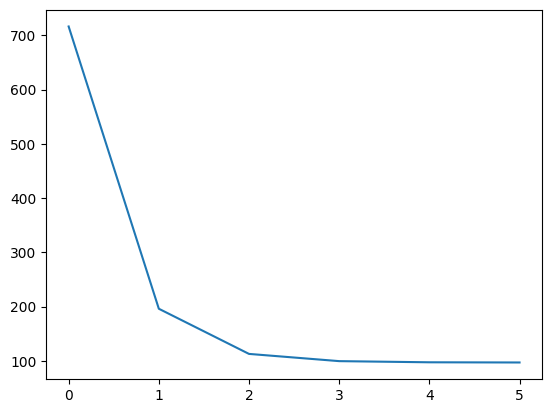

In [36]:
# Brute force para encontrar el mejor número de epochs y learning rate

nn = NeuralNet()
loss = nn.fit(X_train, y_train, lr=0.1, epochs=6)
display(loss[-1])
plt.plot(loss)

97.11799019656026

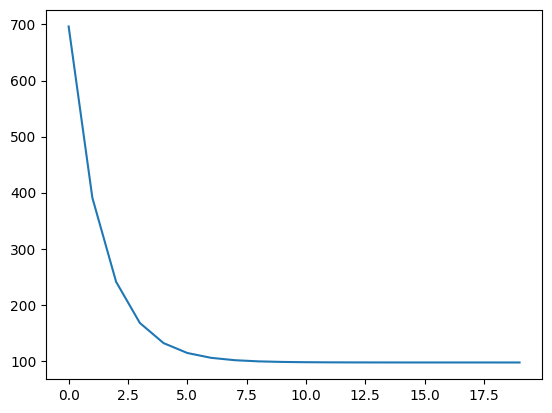

In [37]:
# Brute force para encontrar el mejor número de epochs y learning rate

nn = NeuralNet()
loss = nn.fit(X_train, y_train, lr=0.05, epochs=20)
display(loss[-1][0])
_ = plt.plot(loss)

In [38]:
import itertools

In [39]:
# Brute force para encontrar el mejor número de epochs y learning rate

nn = NeuralNet()
lrs = np.linspace(0.001, 0.5, 100)
eps = np.linspace(1, 3000, 100)

losses = {}

for lr, ep in tqdm(list(itertools.product(lrs, eps))):
    if losses.get((lr, ep)):
        continue
    nn = NeuralNet()
    nn.fit(X_train, y_train, lr=lr, epochs=int(ep))
    
    losses[(lr, ep)] = nn.get_loss()[-1][0]

 73%|███████▎  | 7267/10000 [12:10:38<5:31:16,  7.27s/it]  /Users/nacho/Desktop/code/TP2_Metodos/NeuralNet.py:27: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 10000/10000 [16:28:19<00:00,  5.93s/it] 


In [118]:
# Display loss with all digits (not rounded)

pd.options.display.float_format = '{:,.20f}'.format

In [121]:
# 16:28:19 | 100%|██████████| 10000/10000 [16:28:19<00:00,  5.93s/it] 

losses_arr = []
for (lr, ep), loss in losses.items():
    losses_arr.append((lr, int(ep), loss))

losses_df = pd.DataFrame(losses_arr, columns=['lr', 'epochs', 'loss'])
losses_df.sort_values('loss', ascending=True)

,lr,epochs,loss
4999,0.24797979797979799454,3000,97.11721158982109614044
1159,0.05644444444444444292,1788,97.11721158982109614044
2631,0.13205050505050505705,940,97.11721158982109614044
5463,0.27318181818181819231,1909,97.11721158982109614044
2633,0.13205050505050505705,1000,97.11721158982109614044
...,...,...,...
9779,0.48991919191919192089,2394,"1,435,401,077,619,303,997,343,063,786,904,147,5..."
8182,0.40927272727272728803,2485,"1,780,781,117,962,559,295,186,016,846,620,140,1..."
9198,0.45967676767676768357,2969,"2,246,412,496,813,791,114,442,843,485,262,540,4..."
9417,0.47479797979797977447,515,"38,350,810,004,678,551,099,403,019,593,266,800,..."


In [122]:
losses_df = losses_df[losses_df['loss'] < 100]
losses_df = losses_df.sort_values('loss', ascending=True)
losses_df.head(10)

,lr,epochs,loss
3627,0.18245454545454545259,818,97.11721158982109614044
4564,0.22781818181818180857,1939,97.11721158982109614044
1774,0.08668686868686868718,2242,97.11721158982109614044
1773,0.08668686868686868718,2212,97.11721158982109614044
4570,0.22781818181818180857,2121,97.11721158982109614044
1763,0.08668686868686868718,1909,97.11721158982109614044
1754,0.08668686868686868718,1636,97.11721158982109614044
1747,0.08668686868686868718,1424,97.11721158982109614044
4588,0.22781818181818180857,2666,97.11721158982109614044
4590,0.22781818181818180857,2727,97.11721158982109614044


In [123]:
losses_df_min = losses_df[losses_df['loss'] == losses_df['loss'].min()]
losses_df_min

,lr,epochs,loss
3627,0.18245454545454545259,818,97.11721158982109614044
4564,0.22781818181818180857,1939,97.11721158982109614044
1774,0.08668686868686868718,2242,97.11721158982109614044
1773,0.08668686868686868718,2212,97.11721158982109614044
4570,0.22781818181818180857,2121,97.11721158982109614044
...,...,...,...
803,0.04132323232323232426,91,97.11721158982109614044
5346,0.26814141414141412501,1394,97.11721158982109614044
6538,0.32862626262626265516,1152,97.11721158982109614044
5974,0.29838383838383836233,2242,97.11721158982109614044


In [124]:
losses_df_min.sort_values('epochs', ascending=True).head(10)

,lr,epochs,loss
3401,0.17237373737373737348,31,97.11721158982109614044
2201,0.11188888888888888495,31,97.11721158982109614044
2501,0.12701010101010101749,31,97.11721158982109614044
1702,0.08668686868686868718,61,97.11721158982109614044
5202,0.26310101010101011321,61,97.11721158982109614044
3902,0.19757575757575757125,61,97.11721158982109614044
2802,0.14213131313131313616,61,97.11721158982109614044
5602,0.28326262626262627142,61,97.11721158982109614044
1302,0.06652525252525252897,61,97.11721158982109614044
2903,0.14717171717171717571,91,97.11721158982109614044


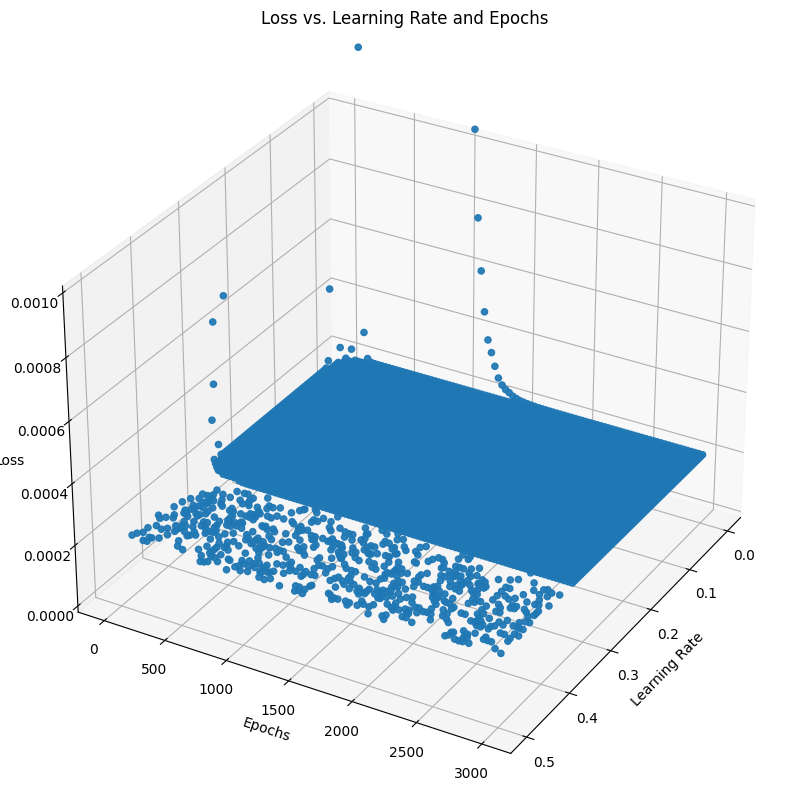

In [89]:
# Plot 3d surface of loss vs. learning rate and epochs

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(losses_df['lr'], losses_df['epochs'], losses_df['loss'])
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Epochs')
ax.set_zlabel('Loss')
ax.set_title('Loss vs. Learning Rate and Epochs')
ax.view_init(30, 30)

# Y limit between 0 and 100
ax.set_zlim(97.117, 97.118)

plt.show()


In [ ]:
# Heatmap

import seaborn as sns

In [90]:
losses_df_hm = losses_df[losses_df['loss'] < 100].pivot('lr', 'epochs', 'loss')
losses_df_hm

epochs,31,61,91,122,152,182,213,243,273,303,...,2727,2757,2787,2818,2848,2878,2909,2939,2969,3000
lr,,,,,,,,,,,,,,,,,,,,,
0.001000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212
0.006040,NaN,NaN,97.927296,97.195964,97.126339,97.118243,97.117309,97.117223,97.117213,97.117212,...,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212
0.011081,NaN,97.276430,97.119791,97.117247,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,...,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212
0.016121,98.394533,97.120536,97.117218,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,...,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212
0.021162,97.295908,97.117258,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,...,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212,97.117212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.479838,NaN,NaN,NaN,97.117212,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,97.117212,97.117212,97.117212,NaN,NaN,NaN,NaN
0.484879,NaN,NaN,97.117212,NaN,NaN,NaN,97.117212,NaN,97.117219,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.489919,NaN,NaN,NaN,NaN,NaN,NaN,97.117220,NaN,NaN,NaN,...,97.117219,NaN,97.117241,NaN,NaN,NaN,NaN,97.117212,NaN,NaN


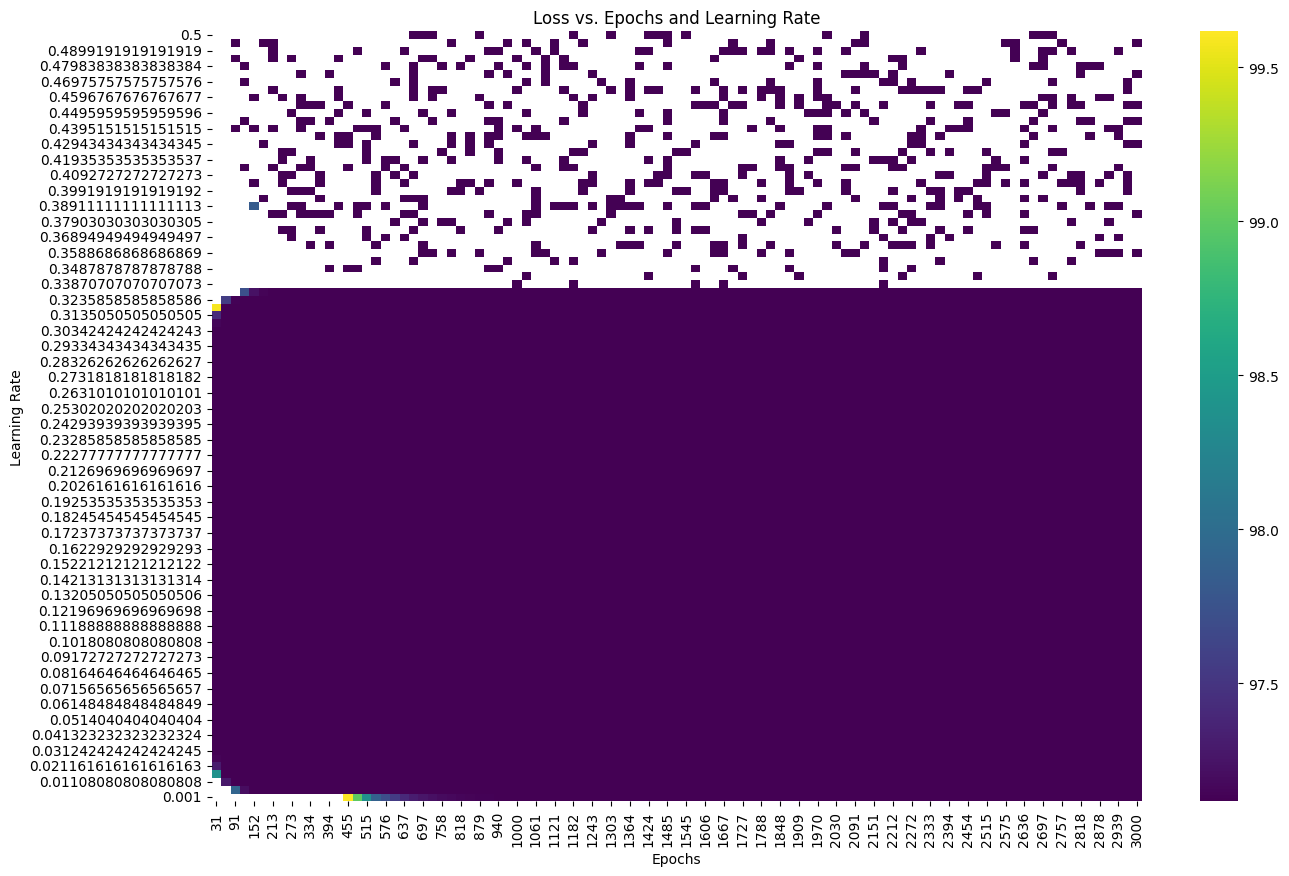

In [91]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(losses_df_hm, ax=ax, cmap='viridis')
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.set_title('Loss vs. Epochs and Learning Rate')
ax.invert_yaxis()
# Hide y labels
#_ = ax.set_yticklabels([])
# Hide x labels
#_ = ax.set_xticklabels([])

# 
plt.show()

In [41]:
import pickle

# save losses

with open('losses.pickle', 'wb') as f:
    pickle.dump(losses, f)

    

In [100]:
# Brute force para encontrar el mejor número de epochs y learning rate

lrs = np.linspace(0.001, 0.5, 100)
eps = np.linspace(1, 30, 30)

losses_30 = {}

for lr, ep in tqdm(list(itertools.product(lrs, eps))):
    if losses_30.get((lr, int(ep))):
        continue
    nn = NeuralNet()
    nn.fit(X_train, y_train, lr=lr, epochs=int(ep))
    
    losses_30[(lr, int(ep))] = nn.get_loss()[-1][0]

100%|██████████| 3000/3000 [03:13<00:00, 15.46it/s]


In [101]:
len(losses_30)

3000

In [119]:
losses_arr_30 = []
for (lr, ep), loss in losses_30.items():
    losses_arr_30.append((lr, int(ep), loss))

losses_df_30 = pd.DataFrame(losses_arr_30, columns=['lr', 'epochs', 'loss'])
losses_df_30.head()

,lr,epochs,loss
0,0.00100000000000000002,1,686.40707225999847196363
1,0.00100000000000000002,2,684.46057930275981107116
2,0.00100000000000000002,3,726.44122762606673404662
3,0.00100000000000000002,4,661.04877864660249997542
4,0.00100000000000000002,5,700.03630600132873951225


In [117]:
# sort by loss and epochs

losses_df_30 = losses_df_30.sort_values(['loss', 'epochs'], ascending=[True, True])

losses_df_30

,lr,epochs,loss
966,0.16229292929292929437,7,97.11721158982109614044
1028,0.17237373737373737348,9,97.11721158982109614044
880,0.14717171717171717571,11,97.11721158982109614044
910,0.15221212121212121526,11,97.11721158982109614044
1030,0.17237373737373737348,11,97.11721158982109614044
...,...,...,...
2968,0.49495959595959598820,29,"20,025,559,189,466,914,816.00000000000000000000"
2939,0.48991919191919192089,30,"29,696,508,617,891,258,368.00000000000000000000"
2998,0.50000000000000000000,29,"43,822,224,310,320,988,160.00000000000000000000"
2969,0.49495959595959598820,30,"74,430,751,231,629,623,296.00000000000000000000"


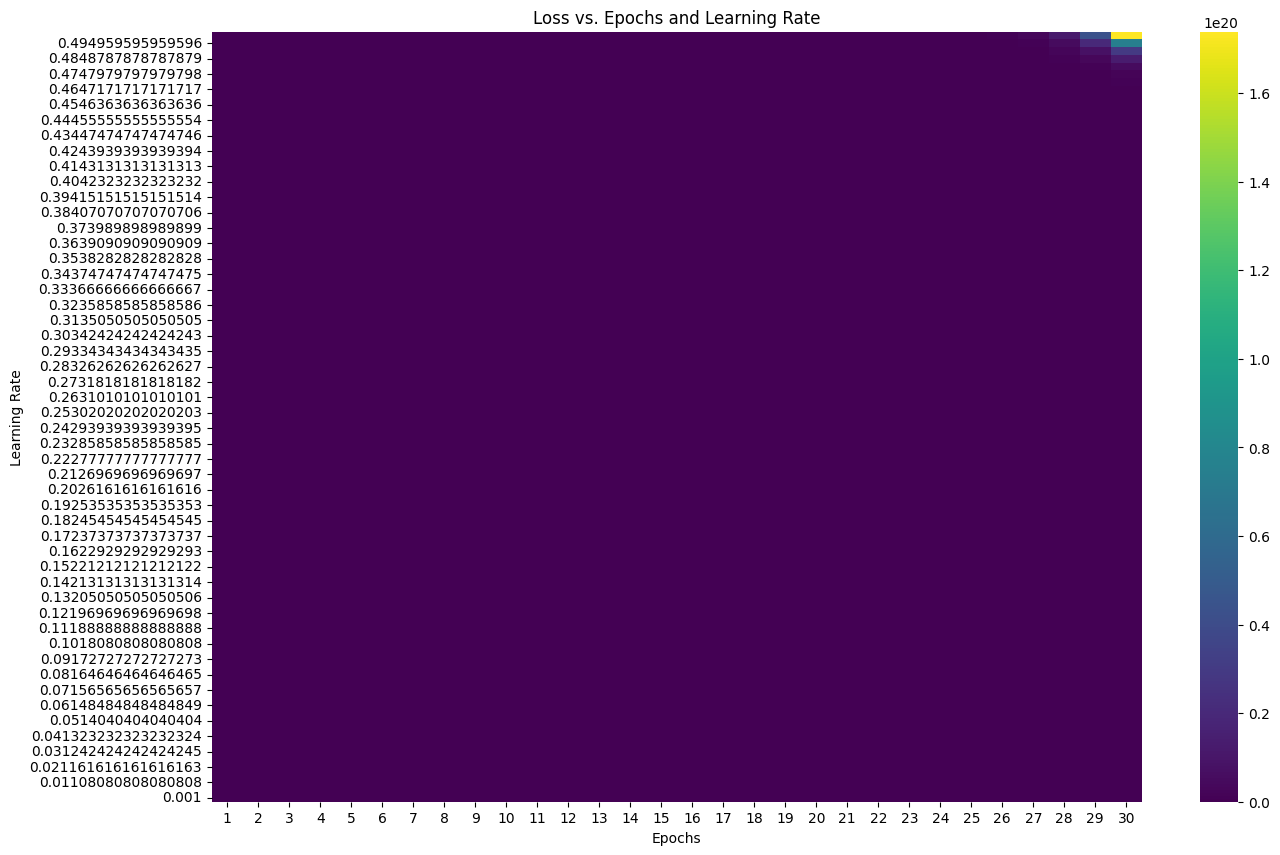

In [113]:
losses_df_hm_30 = losses_df_30.pivot('lr', 'epochs', 'loss')

fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(losses_df_hm_30, ax=ax, cmap='viridis')
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.set_title('Loss vs. Epochs and Learning Rate')
ax.invert_yaxis()
# Hide y labels
#_ = ax.set_yticklabels([])
# Hide x labels
#_ = ax.set_xticklabels([])
plt.show()

In [156]:
nn_7 = NeuralNet()
loss = nn_7.fit(X_train, y_train, lr=0.16229292929292929437, epochs=7)

nn_7_test_loss = nn.loss(X_test, y_test)[0]
loss[-1][0], nn_7_test_loss

(97.11721158982111, 77.1940659472982)

In [129]:
# First entry of losses_df

losses_df.iloc[0]

lr         0.18245454545454545259
epochs   818.00000000000000000000
loss      97.11721158982109614044
Name: 3627, dtype: float64

In [135]:
nn_818 = NeuralNet()
loss = nn_818.fit(X_train, y_train, lr=0.18245454545454545259, epochs=818)
nn_818_test_loss = nn.loss(X_test, y_test)[0]
loss[-1][0], nn_818_test_loss

(97.11721158982111, 77.1940659472982)

In [137]:
pd.Series([nn_7_test_loss, nn_818_test_loss], index=['7 epochs', '818 epochs'])

7 epochs     77.19406594729819914846
818 epochs   77.19406594729819914846
dtype: float64

In [152]:
nn_7.predict(X_test)[:10]

array([[3.7290953],
       [3.7290953],
       [3.7290953],
       [3.7290953],
       [3.7290953],
       [3.7290953],
       [3.7290953],
       [3.7290953],
       [3.7290953],
       [3.7290953]])

In [150]:
fake_values = np.random.randint(0, 255, (1, 6))
nn_7.predict(fake_values)

array([[3.7290953]])